# Loading the required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

## Logistic Regression model

In [2]:
class LogisticRegression:
    def __init__(self):
        self.w = None  # Initialize weights to None

    def predict(self, X):
        """
        Predicts binary class labels for input data X.

        :param X: Input data of shape (n_samples, n_features).
        :return: Binary class labels (True or False) for each sample.
        """
        ones_column = np.ones((X.shape[0], 1))
        X_with_bias = np.concatenate((ones_column, X), axis=1)
        return (np.dot(X_with_bias, self.w)) > 0

    def sigmoid(self, z):
        """
        Sigmoid activation function.

        :param z: Input value or array.
        :return: Sigmoid function output.
        """
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y, learning_rate=0.001, e=0.0001, max_iter=1000000):
        """
        Fit the logistic regression model to the training data.

        :param X: Input data of shape (n_samples, n_features).
        :param y: Binary target labels of shape (n_samples,).
        :param learning_rate: Learning rate for gradient descent (default: 0.001).
        :param e: Convergence threshold (default: 0.0001).
        :param max_iter: Maximum number of iterations (default: 1000000).
        :return: None
        """
        if self.w is None:  # If weights are None, initialize them based on X's shape
            num_features = X.shape[1]
            self.w = np.zeros(num_features + 1)

        ones_column = np.ones((X.shape[0], 1))
        X_with_bias = np.concatenate((ones_column, X), axis=1)
        n_samples = len(X)
        old_w = np.ones(self.w.shape)
        while np.linalg.norm(self.w - old_w, ord=2) > e and max_iter > 0:
            old_w = self.w.copy()
            predictions = self.sigmoid(np.dot(X_with_bias, self.w))
            gradient = np.dot(X_with_bias.T, (y - predictions))
            self.w += learning_rate * gradient
            max_iter -= 1


## Train test split function

In [3]:
def my_train_test_split(data, labels, test_size=0.2, random_state=None):
    """
    Custom train-test split function for data and labels.

    :param data: The input data.
    :param labels: The corresponding labels for the data.
    :param test_size: The proportion of the data to include in the test split (default: 0.2).
    :param random_state: Seed for random shuffling (default: None).

    :return: X_train, X_test, y_train, y_test
        - X_train: The training data.
        - X_test: The testing data.
        - y_train: The labels for the training data.
        - y_test: The labels for the testing data.
    """
    assert len(data) == len(labels), "Data and labels must have the same length!"
    if random_state is not None:
        random.seed(random_state)

    # Shuffle indices.
    indices = list(data.index)
    random.shuffle(indices)

    # Calculate split index.
    split_idx = int(len(data) * (1 - test_size))

    # Split the data and labels.
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]

    X_train = data.loc[train_indices]
    y_train = labels.loc[train_indices]

    X_test = data.loc[test_indices]
    y_test = labels.loc[test_indices]

    return X_train, X_test, y_train, y_test


## K fold cross validation function

In [4]:
def Accu_eval(true_labels, predictions):
    """
    Calculate the accuracy of a classification model.

    :param true_labels: The true labels (ground truth) for the data.
    :param predictions: The predicted labels made by a classification model.

    :return: The accuracy, which is the proportion of correctly predicted labels.
    """
    return np.mean(true_labels == predictions)


In [5]:
def k_fold_split(data, k=10, random_state=None):
    """
    Splits the data into k folds for cross-validation.

    Parameters:
    - data: DataFrame of data points.
    - k: Number of folds.
    - random_state: Seed for random number generator.

    Returns:
    - folds: List of k DataFrames.
    """

    if random_state is not None:
        np.random.seed(random_state)

    # Randomly shuffle the data
    shuffled_data = data.sample(frac=1, random_state=random_state).reset_index(
        drop=True
    )

    # Split the data into k roughly equal parts
    n = len(shuffled_data)
    fold_size = n // k
    folds = []
    for i in range(k):
        if i < k - 1:
            fold = shuffled_data.iloc[i * fold_size : (i + 1) * fold_size]
        else:
            # The last fold might have more than fold_size elements
            fold = shuffled_data.iloc[i * fold_size :]
        folds.append(fold)

    return folds


def k_fold_cross_validation(model, data, labels, k=5, random_state=None):
    """
    Conducts k-fold cross-validation on the data with the given model.

    Parameters:
    - model: A machine learning model with fit and predict methods.
    - data: DataFrame of data points.
    - labels: DataFrame or Series of labels corresponding to the data.
    - k: Number of folds.
    - random_state: Seed for random number generator.

    Returns:
    - scores: List of accuracy scores for each fold.
    """

    data_folds = k_fold_split(data, k, random_state)
    label_folds = k_fold_split(labels, k, random_state)

    scores = []

    for i in range(k):
        # Split the data into training and validation sets
        train_data = pd.concat(
            [fold for j, fold in enumerate(data_folds) if j != i], ignore_index=True
        )
        train_labels = pd.concat(
            [fold for j, fold in enumerate(label_folds) if j != i], ignore_index=True
        )

        validation_data = data_folds[i]
        validation_labels = label_folds[i]

        # Train the model
        model.fit(train_data, train_labels)

        # Predict on the validation set
        predictions = model.predict(validation_data)

        # Calculate accuracy
        accuracy = Accu_eval(validation_labels, predictions)
        scores.append(accuracy)

    return scores, model

## RFE function

In [6]:
def rfe(Model_Class, X, y, train_test_split):
    """
    Recursive Feature Elimination (RFE) using a specified model class.

    :param Model_Class: The class of the model to be used for feature elimination.
    :param X: The input features.
    :param y: The target labels.
    :param train_test_split: A function for splitting the data into training and testing sets.

    :return: A dictionary containing feature names ordered by their elimination sequence.
    """
    X = X.copy()
    weights_ordered = dict()
    while True:
        X_train, _, y_train, _ = train_test_split(
            X, y, test_size=0.2, random_state=42)
        model = Model_Class()
        model.fit(X_train, y_train)
        weights = model.w[1:]  # The first weight is the bias we added
        smallest_weight_index = np.argmin(weights)
        smallest_weight_name = X.columns[smallest_weight_index]
        X = X.drop(columns=smallest_weight_name)
        weights_ordered[smallest_weight_name] = len(weights)
        if len(weights) == 1:
            break
    weights_ordered_descending = dict(sorted(weights_ordered.items(), key=lambda item: item[1]))
    return weights_ordered_descending



# Data Loading

In [7]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/ML Colab Notebooks/Hepatits.csv"

Mounted at /content/drive


In [8]:
# file_path = "C:/Users/futaba/Downloads/Hepatits.csv"

In [9]:
columns = [
    "Ascites",
    "Varices",
    "Bilirubin",
    "Alk Phosphate",
    "Sgot",
    "Albumin",
    "Protime",
    "Histology",
    "Y",
]
df = pd.read_csv(file_path, header=None, names=columns)

# Getting familiar with the data and data visualization

In [10]:
df.head()

,Ascites,Varices,Bilirubin,Alk Phosphate,Sgot,Albumin,Protime,Histology,Y
0,0.117650,0.77889,0.42623,0.27273,0.638300,0.57675,0.069172,0.066667,1
1,0.176470,0.40201,0.67213,0.31313,0.082742,0.50969,0.518360,0.100000,1
2,0.058824,1.00000,0.62295,0.43434,0.000000,0.63934,0.561910,0.016667,1
3,0.470590,0.83920,0.86885,0.46465,0.273050,0.56036,0.037148,0.366670,1
4,0.529410,0.72864,0.65574,0.46465,0.153660,0.56483,0.238680,0.316670,1


## Histogram of features

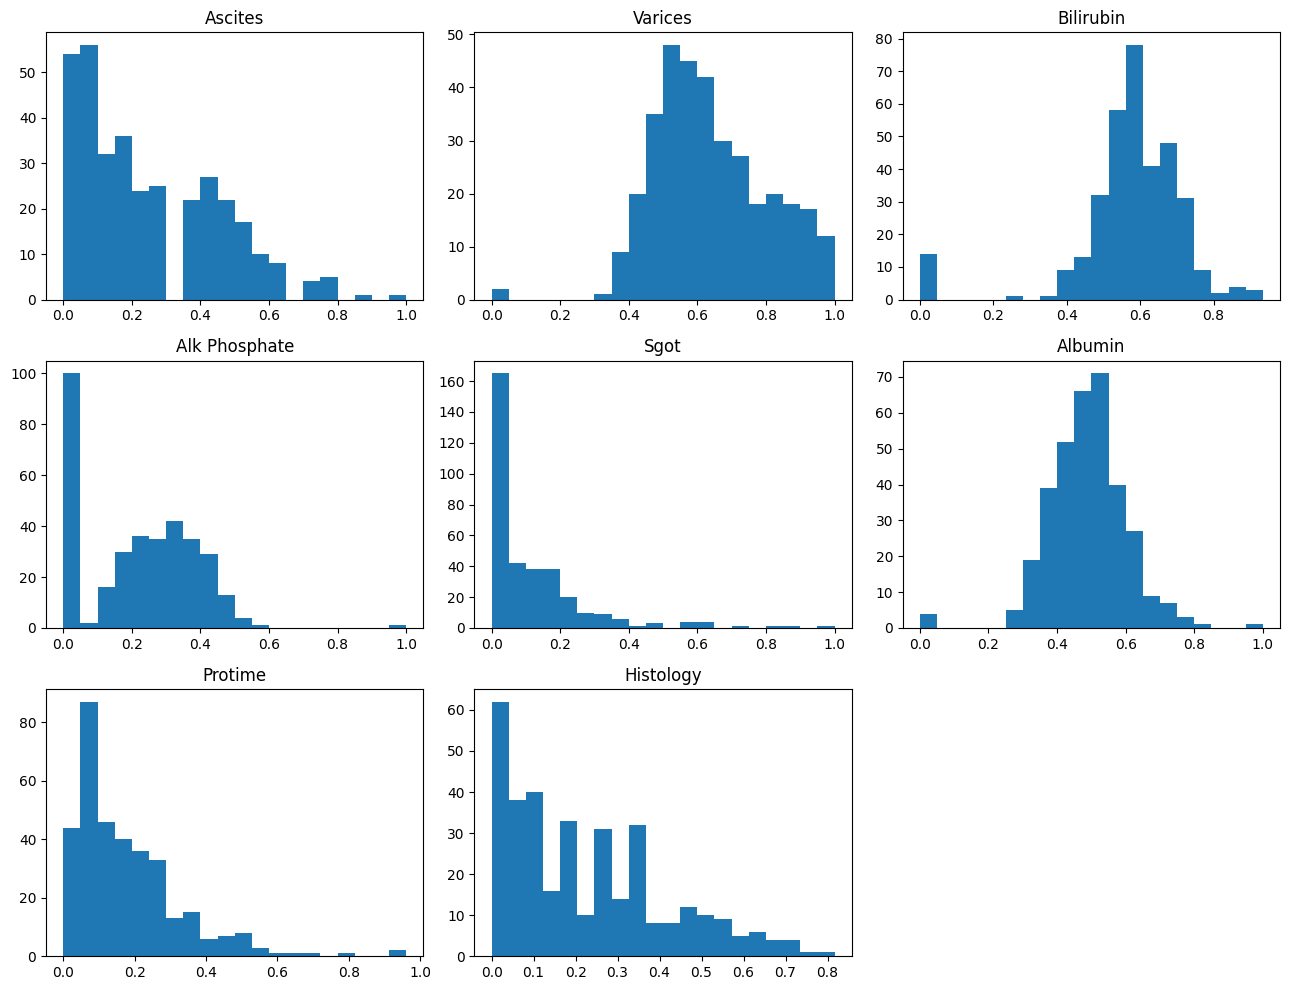

In [11]:
features_columns = columns[:-1]
features = df.loc[:, features_columns]
features.hist(figsize=(13, 10), bins=20, grid=False)
plt.tight_layout()
plt.show()

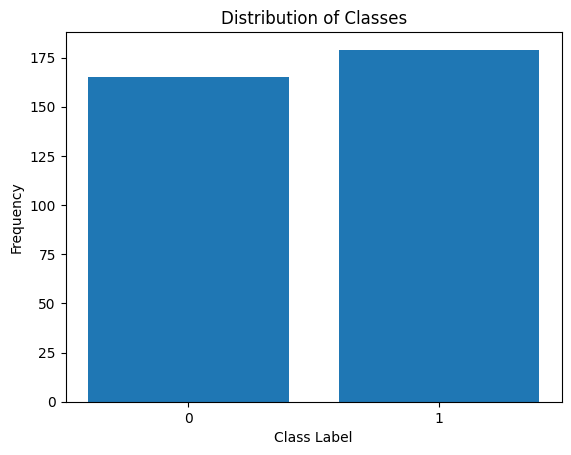

In [12]:
class_data = df.loc[:, "Y"]
unique, counts = np.unique(class_data, return_counts=True)
plt.bar(unique, counts, tick_label=["0", "1"])
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Distribution of Classes")
plt.show()

## Distribution of features

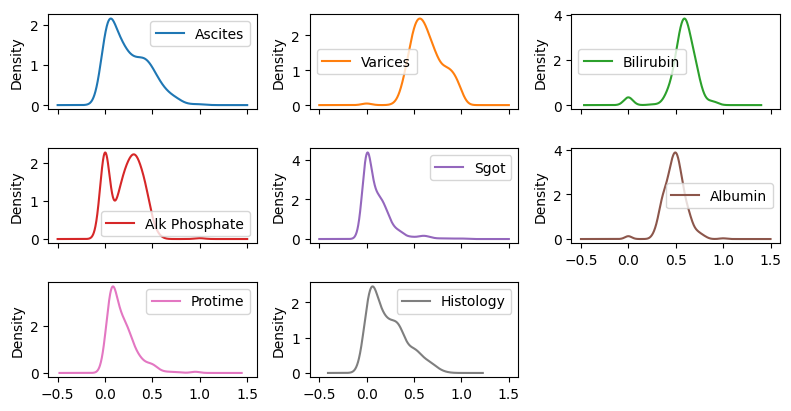

In [13]:
features.plot(kind="density", subplots=True, layout=(6, 3), sharex=True, figsize=(8, 8))
plt.tight_layout()
plt.show()

## Corelation matrix of the features (also with class)

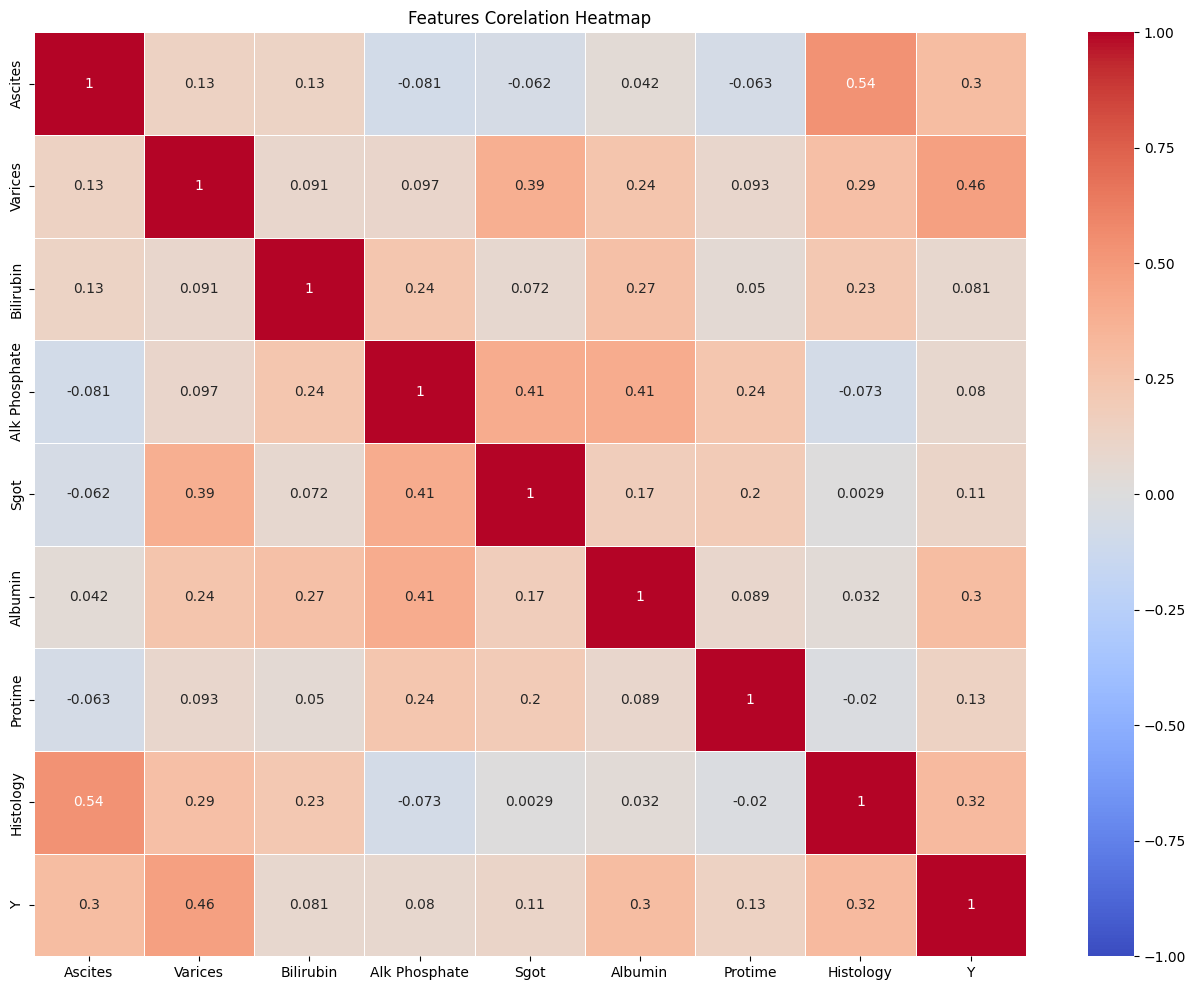

In [14]:
corelation_matrix = df.loc[:, columns].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(
    corelation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1
)
plt.title("Features Corelation Heatmap")
plt.show()

## Pair plot of features (also with class)

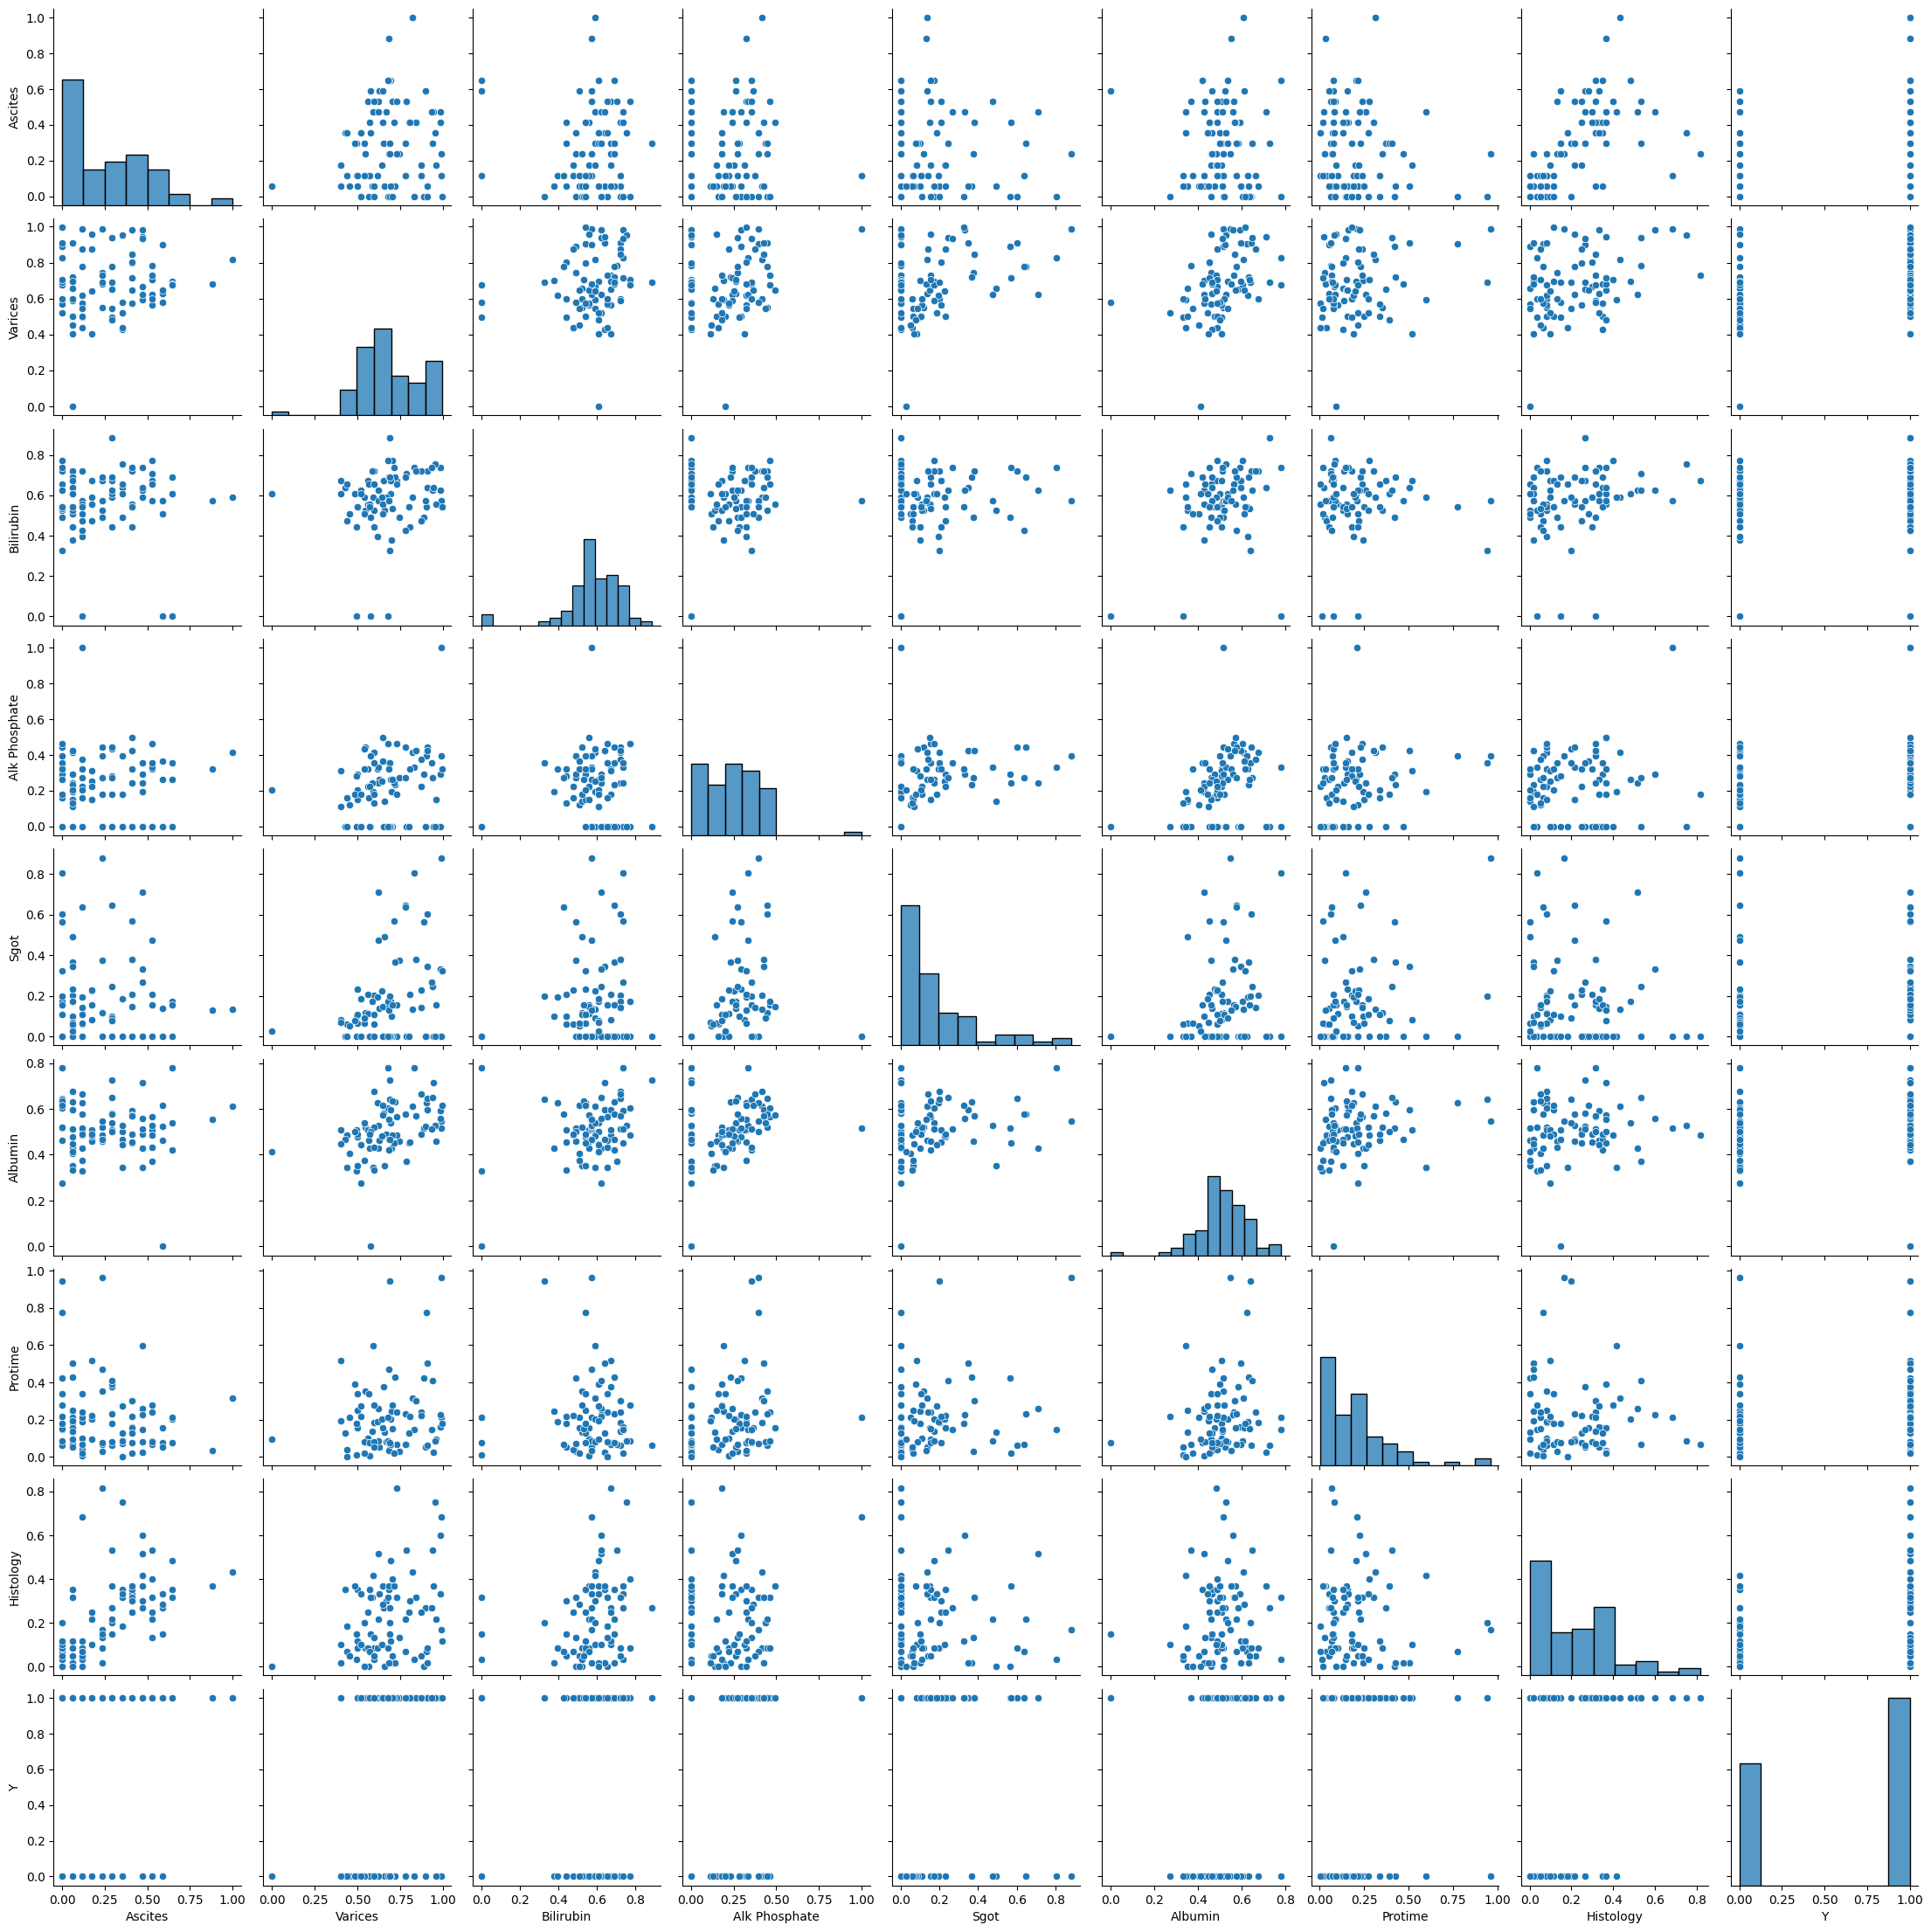

In [15]:
sns.pairplot(
    df.loc[:, columns].sample(frac=0.25)
)  # Here, using a 10% sample for demonstration
plt.show()

## Some statistics on the data

In [16]:
features.describe()

,Ascites,Varices,Bilirubin,Alk Phosphate,Sgot,Albumin,Protime,Histology
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000
mean,0.244870,0.639798,0.576844,0.214265,0.107747,0.489208,0.179322,0.224806
std,0.209697,0.166002,0.152817,0.167098,0.154989,0.117136,0.148235,0.190969
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.517590,0.524590,0.000000,0.000000,0.421388,0.075149,0.066667
50%,0.176470,0.613070,0.590160,0.232320,0.059102,0.490310,0.137490,0.183330
75%,0.411760,0.744975,0.655740,0.333330,0.166662,0.553283,0.247970,0.350000
max,1.000000,1.000000,0.934430,1.000000,1.000000,1.000000,0.961140,0.816670


## Data visualization and statistics of each class (Separately)

### Hepatitis class

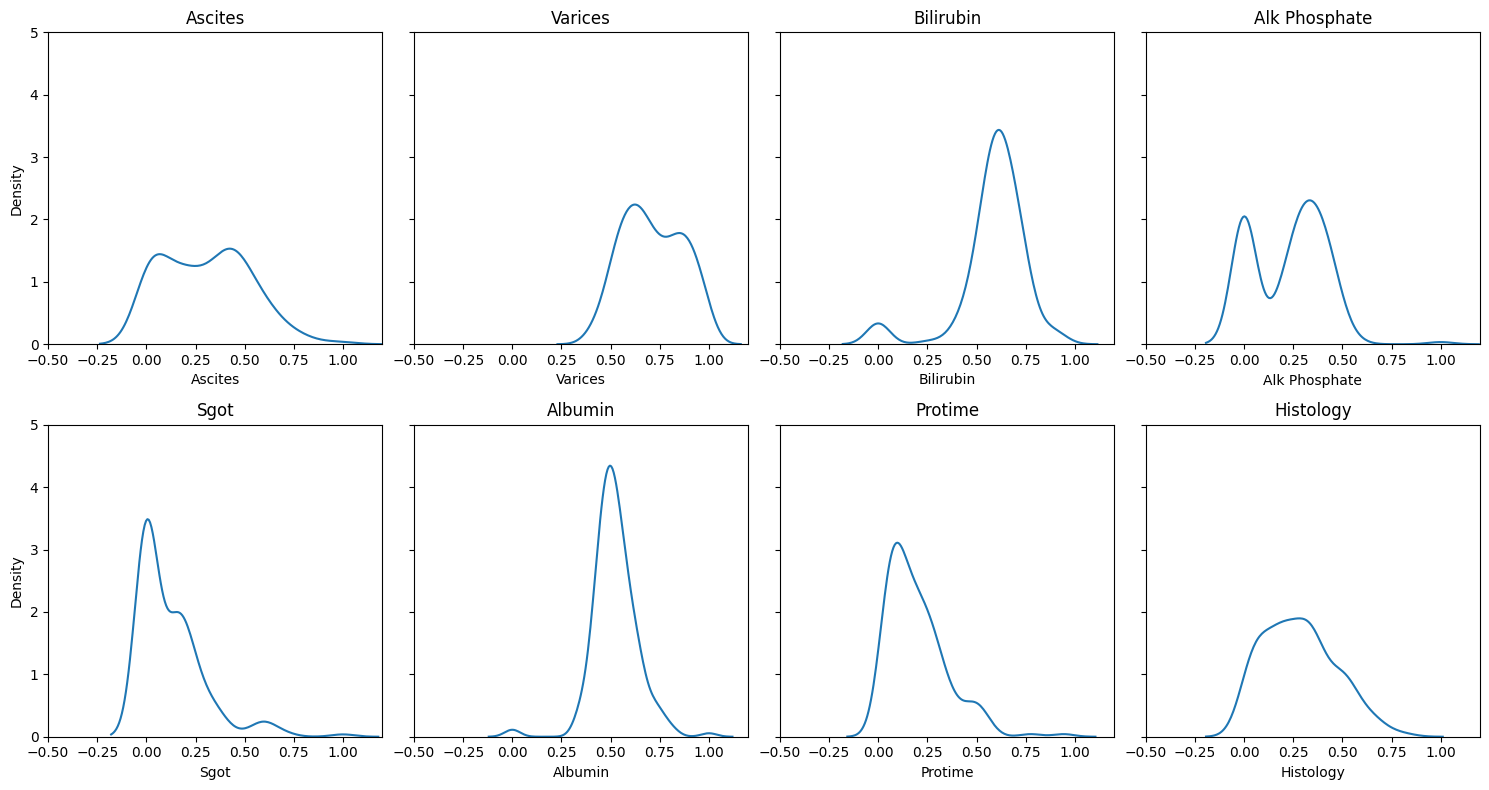

,Ascites,Varices,Bilirubin,Alk Phosphate,Sgot,Albumin,Protime,Histology
count,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000
mean,0.304962,0.713652,0.588652,0.227075,0.124444,0.522567,0.198243,0.282495
std,0.222160,0.152647,0.169803,0.182474,0.168946,0.112793,0.151895,0.182397
min,0.000000,0.391960,0.000000,0.000000,0.000000,0.000000,0.004270,0.000000
25%,0.117650,0.592960,0.540980,0.000000,0.000000,0.461255,0.077925,0.133330
50%,0.294120,0.693470,0.606560,0.272730,0.056738,0.511180,0.160970,0.266670
75%,0.470590,0.844220,0.672130,0.363640,0.189130,0.575260,0.274765,0.400000
max,1.000000,1.000000,0.934430,1.000000,1.000000,1.000000,0.943640,0.816670


In [17]:
positive_samples = df[df["Y"] == 1]
positive_samples_without_label = positive_samples.loc[:, features_columns]
fig, axes = plt.subplots(
    2, len(features_columns) // 2, figsize=(15, len(features_columns)), sharey=True
)

# Set global y-axis limits
for row_axes in axes:
    for ax in row_axes:
        ax.set_ylim(0, 5)
        ax.set_xlim(-0.5, 1.2)


for col, ax in zip(features_columns, axes.ravel()):
    sns.kdeplot(positive_samples_without_label[col], ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()
positive_samples_without_label.describe()

### Normal class

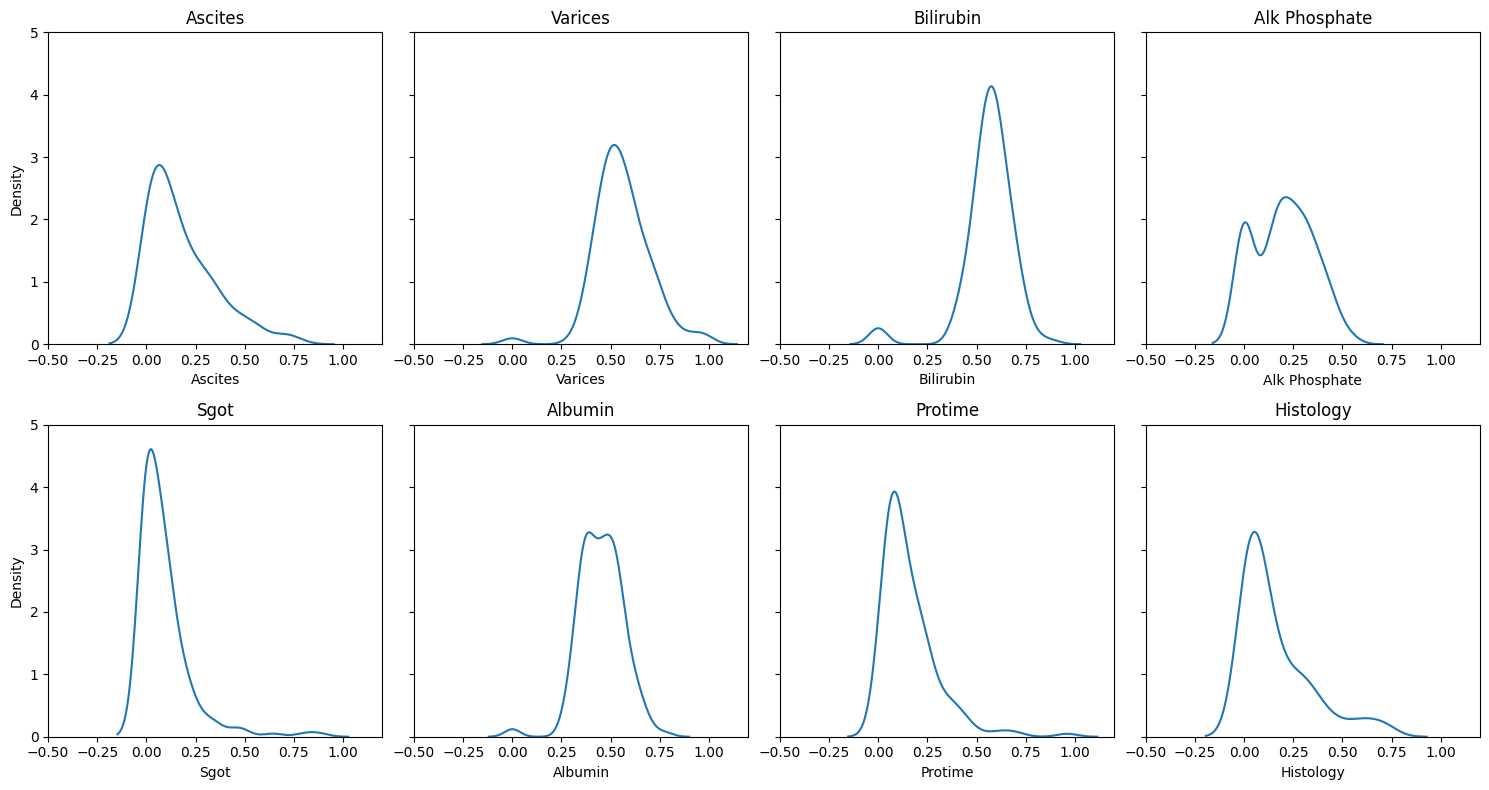

,Ascites,Varices,Bilirubin,Alk Phosphate,Sgot,Albumin,Protime,Histology
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,0.179679,0.559677,0.564034,0.200367,0.089634,0.453019,0.158794,0.162222
std,0.173730,0.141180,0.131265,0.147934,0.136478,0.111158,0.141776,0.180532
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.477390,0.524590,0.080808,0.000000,0.375560,0.068318,0.033333
50%,0.117650,0.542710,0.573770,0.202020,0.059102,0.454550,0.111870,0.083333
75%,0.294120,0.633170,0.639340,0.313130,0.111110,0.527570,0.214350,0.250000
max,0.764710,0.989950,0.885250,0.545450,0.879430,0.779430,0.961140,0.733330


In [18]:
negative_samples = df[df["Y"] == 0]
negative_samples_without_label = negative_samples.loc[:, features_columns]
fig, axes = plt.subplots(
    2, len(features_columns) // 2, figsize=(15, len(features_columns)), sharey=True
)

# Set global y-axis limits
for row_axes in axes:
    for ax in row_axes:
        ax.set_ylim(0, 5)
        ax.set_xlim(-0.5, 1.2)
# Plot each feature's KDE on a separate subplot


for col, ax in zip(features_columns, axes.ravel()):
    sns.kdeplot(negative_samples_without_label[col], ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()
negative_samples_without_label.describe()

# Hepatitis dataset

## feature Selection

### basic features

In [19]:
# First we select all of the given features
all_features = [
    "Ascites",
    "Varices",
    "Bilirubin",
    "Alk Phosphate",
    "Sgot",
    "Albumin",
    "Protime",
    "Histology",
]

### Spliting data into train and test data

In [20]:
X = df.loc[:, all_features]
y = df.loc[:, "Y"]
X_train, X_test, y_train, y_test = my_train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [21]:
weight_importance = rfe(LogisticRegression, X, y, my_train_test_split)
print(weight_importance)

{'Varices': 1, 'Ascites': 2, 'Albumin': 3, 'Protime': 4, 'Histology': 5, 'Alk Phosphate': 6, 'Bilirubin': 7, 'Sgot': 8}


###  Validating model with cross validation

In [22]:
model = LogisticRegression()
scores, trained_model = k_fold_cross_validation(
    model, X_train, y_train, k=10, random_state=42
)
best_score_mean = np.mean(scores)
print("best score mean: ", best_score_mean)

best score mean:  0.728587962962963


In [23]:
model = LogisticRegression()
model.fit(X_train, y_train)
Accu_eval(y_test, model.predict(X_test))

0.7101449275362319

### Feature engineering

1. basis expantion (order 2)

In [24]:
# Extract the original features from the DataFrame
X_engineered = df.loc[:, all_features]

# Create an empty DataFrame to store the new squared features
new_features_df = pd.DataFrame()

# Iterate through the original features and create squared features
for i in range(len(all_features)):
    new_col_name = all_features[i] + "^2"  # Name for the new squared feature
    new_features_df[new_col_name] = X_engineered[all_features[i]] ** 2  # Calculate the squared feature

# Append the new squared features to the original DataFrame
X_engineered = pd.concat([X_engineered, new_features_df], axis=1)

# Display the first few rows of the engineered DataFrame
X_engineered.head()


,Ascites,Varices,Bilirubin,Alk Phosphate,Sgot,Albumin,Protime,Histology,Ascites^2,Varices^2,Bilirubin^2,Alk Phosphate^2,Sgot^2,Albumin^2,Protime^2,Histology^2
0,0.117650,0.77889,0.42623,0.27273,0.638300,0.57675,0.069172,0.066667,0.013842,0.606670,0.181672,0.074382,0.407427,0.332641,0.004785,0.004444
1,0.176470,0.40201,0.67213,0.31313,0.082742,0.50969,0.518360,0.100000,0.031142,0.161612,0.451759,0.098050,0.006846,0.259784,0.268697,0.010000
2,0.058824,1.00000,0.62295,0.43434,0.000000,0.63934,0.561910,0.016667,0.003460,1.000000,0.388067,0.188651,0.000000,0.408756,0.315743,0.000278
3,0.470590,0.83920,0.86885,0.46465,0.273050,0.56036,0.037148,0.366670,0.221455,0.704257,0.754900,0.215900,0.074556,0.314003,0.001380,0.134447
4,0.529410,0.72864,0.65574,0.46465,0.153660,0.56483,0.238680,0.316670,0.280275,0.530916,0.429995,0.215900,0.023611,0.319033,0.056968,0.100280


In [25]:
# Split the engineered data into training and testing sets
X_engineered_train, X_engineered_test, y_train, y_test = my_train_test_split(
    X_engineered, y, test_size=0.2, random_state=42
)

# Create a LogisticRegression model instance
model = LogisticRegression()

# Perform k-fold cross-validation and get scores for each fold
scores, trained_model = k_fold_cross_validation(
    model, X_engineered_train, y_train, k=10, random_state=42
)

# Calculate the mean of the best scores obtained from cross-validation
best_score_mean = np.mean(scores)

# Print the mean of the best scores
print("best score mean: ", best_score_mean)


best score mean:  0.7155092592592593


In [26]:
weight_importance = rfe(LogisticRegression, X_engineered, y, my_train_test_split)
print(weight_importance)


{'Varices': 1, 'Albumin^2': 2, 'Ascites': 3, 'Ascites^2': 4, 'Histology': 5, 'Protime': 6, 'Varices^2': 7, 'Albumin': 8, 'Bilirubin^2': 9, 'Alk Phosphate^2': 10, 'Alk Phosphate': 11, 'Sgot': 12, 'Bilirubin': 13, 'Sgot^2': 14, 'Protime^2': 15, 'Histology^2': 16}


2. basis expantion (order 3)

In [27]:
# Extract the original features from the DataFrame
X_engineered = df.loc[:, all_features]

# Create an empty DataFrame to store the new cubic features
new_features_df = pd.DataFrame()

# Iterate through the original features and create cubic features
for i in range(len(all_features)):
    new_col_name = all_features[i] + "^3"  # Name for the new cubic feature
    new_features_df[new_col_name] = X_engineered[all_features[i]] ** 3  # Calculate the cubic feature

# Append the new cubic features to the original DataFrame
X_engineered = pd.concat([X_engineered, new_features_df], axis=1)

# Display the first few rows of the engineered DataFrame
X_engineered.head()


,Ascites,Varices,Bilirubin,Alk Phosphate,Sgot,Albumin,Protime,Histology,Ascites^3,Varices^3,Bilirubin^3,Alk Phosphate^3,Sgot^3,Albumin^3,Protime^3,Histology^3
0,0.117650,0.77889,0.42623,0.27273,0.638300,0.57675,0.069172,0.066667,0.001628,0.472529,0.077434,0.020286,0.260061,0.191850,0.000331,0.000296
1,0.176470,0.40201,0.67213,0.31313,0.082742,0.50969,0.518360,0.100000,0.005496,0.064970,0.303641,0.030703,0.000566,0.132409,0.139282,0.001000
2,0.058824,1.00000,0.62295,0.43434,0.000000,0.63934,0.561910,0.016667,0.000204,1.000000,0.241746,0.081939,0.000000,0.261334,0.177419,0.000005
3,0.470590,0.83920,0.86885,0.46465,0.273050,0.56036,0.037148,0.366670,0.104214,0.591012,0.655895,0.100318,0.020358,0.175955,0.000051,0.049298
4,0.529410,0.72864,0.65574,0.46465,0.153660,0.56483,0.238680,0.316670,0.148380,0.386847,0.281965,0.100318,0.003628,0.180199,0.013597,0.031756


In [28]:
# Split the engineered data into training and testing sets
X_engineered_train, X_engineered_test, y_train, y_test = my_train_test_split(
    X_engineered, y, test_size=0.2, random_state=42
)

# Create a LogisticRegression model instance
model = LogisticRegression()

# Perform k-fold cross-validation and get scores for each fold
scores, trained_model = k_fold_cross_validation(
    model, X_engineered_train, y_train, k=10, random_state=42
)

# Calculate the mean of the scores obtained from the cross-validation
best_score_mean = np.mean(scores)

# Print the mean score as an estimate of model performance
print("best score mean: ", best_score_mean)


best score mean:  0.7155092592592593


In [29]:
weight_importance = rfe(LogisticRegression, X_engineered, y, my_train_test_split)
print(weight_importance)

{'Varices': 1, 'Albumin^3': 2, 'Ascites': 3, 'Albumin': 4, 'Protime': 5, 'Histology': 6, 'Ascites^3': 7, 'Varices^3': 8, 'Alk Phosphate^3': 9, 'Bilirubin^3': 10, 'Alk Phosphate': 11, 'Sgot': 12, 'Bilirubin': 13, 'Sgot^3': 14, 'Protime^3': 15, 'Histology^3': 16}


3. interaction terms

In [30]:
# Extract the original features from the DataFrame
X_engineered = df.loc[:, all_features]

# Create an empty DataFrame to store the new interaction features
new_features_df = pd.DataFrame()

# Iterate through pairs of original features to create interaction features
for i in range(len(all_features)):
    for j in range(i + 1, len(all_features)):
        new_col_name = all_features[i] + "X" + all_features[j]  # Name for the new interaction feature
        new_features_df[new_col_name] = (
            X_engineered[all_features[i]] * X_engineered[all_features[j]]  # Calculate the interaction feature
        )

# Append the new interaction features to the original DataFrame
X_engineered = pd.concat([X_engineered, new_features_df], axis=1)

# To update a selected_features list (not shown in the code, assuming you have this list)

# Display the first few rows of the engineered DataFrame
X_engineered.head()


,Ascites,Varices,Bilirubin,Alk Phosphate,Sgot,Albumin,Protime,Histology,AscitesXVarices,AscitesXBilirubin,...,Alk PhosphateXSgot,Alk PhosphateXAlbumin,Alk PhosphateXProtime,Alk PhosphateXHistology,SgotXAlbumin,SgotXProtime,SgotXHistology,AlbuminXProtime,AlbuminXHistology,ProtimeXHistology
0,0.117650,0.77889,0.42623,0.27273,0.638300,0.57675,0.069172,0.066667,0.091636,0.050146,...,0.174084,0.157297,0.018865,0.018182,0.368140,0.044152,0.042554,0.039895,0.038450,0.004611
1,0.176470,0.40201,0.67213,0.31313,0.082742,0.50969,0.518360,0.100000,0.070943,0.118611,...,0.025909,0.159599,0.162314,0.031313,0.042173,0.042890,0.008274,0.264203,0.050969,0.051836
2,0.058824,1.00000,0.62295,0.43434,0.000000,0.63934,0.561910,0.016667,0.058824,0.036644,...,0.000000,0.277691,0.244060,0.007239,0.000000,0.000000,0.000000,0.359252,0.010656,0.009365
3,0.470590,0.83920,0.86885,0.46465,0.273050,0.56036,0.037148,0.366670,0.394919,0.408872,...,0.126873,0.260371,0.017261,0.170373,0.153006,0.010143,0.100119,0.020816,0.205467,0.013621
4,0.529410,0.72864,0.65574,0.46465,0.153660,0.56483,0.238680,0.316670,0.385749,0.347155,...,0.071398,0.262448,0.110903,0.147141,0.086792,0.036676,0.048660,0.134814,0.178865,0.075583


In [31]:
# Split the engineered data into training and testing sets
X_engineered_train, X_engineered_test, y_train, y_test = my_train_test_split(
    X_engineered, y, test_size=0.2, random_state=42
)

# Create a LogisticRegression model instance
model = LogisticRegression()

# Perform k-fold cross-validation and get scores for each fold
scores, trained_model = k_fold_cross_validation(
    model, X_engineered_train, y_train, k=10, random_state=42
)

# Calculate the mean of the scores obtained from the cross-validation
best_score_mean = np.mean(scores)

# Print the mean score as an estimate of model performance
print("best score mean: ", best_score_mean)


best score mean:  0.7550925925925926


In [32]:
weight_importance = rfe(LogisticRegression, X_engineered, y, my_train_test_split)
print(weight_importance)

{'ProtimeXHistology': 1, 'VaricesXAlbumin': 2, 'Ascites': 3, 'Varices': 4, 'Albumin': 5, 'AlbuminXProtime': 6, 'AscitesXProtime': 7, 'AscitesXVarices': 8, 'Histology': 9, 'BilirubinXProtime': 10, 'BilirubinXHistology': 11, 'VaricesXHistology': 12, 'Alk PhosphateXHistology': 13, 'AscitesXAlk Phosphate': 14, 'Alk PhosphateXProtime': 15, 'Alk PhosphateXAlbumin': 16, 'VaricesXAlk Phosphate': 17, 'SgotXHistology': 18, 'AscitesXSgot': 19, 'Alk PhosphateXSgot': 20, 'SgotXAlbumin': 21, 'Sgot': 22, 'BilirubinXSgot': 23, 'Alk Phosphate': 24, 'AscitesXBilirubin': 25, 'VaricesXBilirubin': 26, 'Bilirubin': 27, 'BilirubinXAlk Phosphate': 28, 'VaricesXSgot': 29, 'BilirubinXAlbumin': 30, 'AlbuminXHistology': 31, 'Protime': 32, 'VaricesXProtime': 33, 'SgotXProtime': 34, 'AscitesXAlbumin': 35, 'AscitesXHistology': 36}


In [33]:
X_engineered.head()
X_engineered.describe()

,Ascites,Varices,Bilirubin,Alk Phosphate,Sgot,Albumin,Protime,Histology,AscitesXVarices,AscitesXBilirubin,...,Alk PhosphateXSgot,Alk PhosphateXAlbumin,Alk PhosphateXProtime,Alk PhosphateXHistology,SgotXAlbumin,SgotXProtime,SgotXHistology,AlbuminXProtime,AlbuminXHistology,ProtimeXHistology
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,...,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000
mean,0.244870,0.639798,0.576844,0.214265,0.107747,0.489208,0.179322,0.224806,0.161295,0.145461,...,0.033576,0.112740,0.044305,0.045859,0.055874,0.023937,0.024309,0.089261,0.110694,0.039759
std,0.209697,0.166002,0.152817,0.167098,0.154989,0.117136,0.148235,0.190969,0.148805,0.137534,...,0.052742,0.100428,0.056490,0.067606,0.084487,0.058197,0.059338,0.080354,0.096635,0.051247
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.517590,0.524590,0.000000,0.000000,0.421388,0.075149,0.066667,0.036728,0.033751,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.034444,0.027521,0.007216
50%,0.176470,0.613070,0.590160,0.232320,0.059102,0.490310,0.137490,0.183330,0.121343,0.108967,...,0.010232,0.103951,0.027056,0.016077,0.023680,0.004801,0.000000,0.068070,0.085147,0.020278
75%,0.411760,0.744975,0.655740,0.333330,0.166662,0.553283,0.247970,0.350000,0.263080,0.231437,...,0.049806,0.177590,0.059152,0.072223,0.085279,0.030300,0.022459,0.117885,0.176960,0.052300
max,1.000000,1.000000,0.934430,1.000000,1.000000,1.000000,0.961140,0.816670,0.819100,0.714568,...,0.346443,0.517140,0.378631,0.683330,0.626490,0.845255,0.633330,0.606119,0.428411,0.326781


4. Removing unnecessary features

In [34]:
# based on the distribution and correlation of the features with the clasess, we assume Bilirubin,
# Alk Phosphate, and sgot are not that informative and discriminative. So, we remove them
selected_features = ["Ascites", "Varices", "Albumin", "Protime", "Histology"]

In [35]:
X_engineered = df.loc[:, selected_features]
X_engineered_train, X_engineered_test, y_train, y_test = my_train_test_split(
    X_engineered, y, test_size=0.2, random_state=42
)
X_engineered.head()

,Ascites,Varices,Albumin,Protime,Histology
0,0.117650,0.77889,0.57675,0.069172,0.066667
1,0.176470,0.40201,0.50969,0.518360,0.100000
2,0.058824,1.00000,0.63934,0.561910,0.016667
3,0.470590,0.83920,0.56036,0.037148,0.366670
4,0.529410,0.72864,0.56483,0.238680,0.316670


In [36]:
model = LogisticRegression()

scores, trained_model = k_fold_cross_validation(
    model, X_engineered_train, y_train, k=10, random_state=42
)
best_score_mean = np.mean(scores)
print("best score mean: ", best_score_mean)

best score mean:  0.7291666666666666


In [37]:
weight_importance = rfe(LogisticRegression, X_engineered, y, my_train_test_split)
print(weight_importance)

{'Varices': 1, 'Ascites': 2, 'Albumin': 3, 'Protime': 4, 'Histology': 5}


In [38]:
# Create an empty list to store the names of the new features
new_features = []

# Iterate through pairs of selected features to create interaction features
for i in range(len(selected_features)):
    for j in range(i + 1, len(selected_features)):
        new_col_name = selected_features[i] + "X" + selected_features[j]  # Name for the new interaction feature
        new_features.append(new_col_name)
        X_engineered[new_col_name] = (
            X_engineered[selected_features[i]] * X_engineered[selected_features[j]]  # Calculate the interaction feature
        )

# Iterate through selected features to create squared features
for i in range(len(selected_features)):
    new_col_name = selected_features[i] + "^2"  # Name for the new squared feature
    new_features.append(new_col_name)
    X_engineered[new_col_name] = X_engineered[selected_features[i]] ** 2  # Calculate the squared feature

# Update the selected_features list by adding the new features
selected_features += new_features


In [39]:
X_engineered.columns

Index(['Ascites', 'Varices', 'Albumin', 'Protime', 'Histology',
       'AscitesXVarices', 'AscitesXAlbumin', 'AscitesXProtime',
       'AscitesXHistology', 'VaricesXAlbumin', 'VaricesXProtime',
       'VaricesXHistology', 'AlbuminXProtime', 'AlbuminXHistology',
       'ProtimeXHistology', 'Ascites^2', 'Varices^2', 'Albumin^2', 'Protime^2',
       'Histology^2'],
      dtype='object')

In [40]:
selected_features = [
    "Ascites",
    "Varices",
    "Albumin",
    "Varices^2",
    "Albumin^2",
    "AscitesXVarices",
    'AlbuminXProtime'
]

In [41]:
X_final = X_engineered.loc[:, selected_features]
X_final_train, X_final_test, y_train, y_test = my_train_test_split(
    X_final, y, test_size=0.2, random_state=42
)
model = LogisticRegression()

scores, trained_model = k_fold_cross_validation(
    model, X_final_train, y_train, k=10, random_state=42
)
best_score_mean = np.mean(scores)
print("best score mean: ", best_score_mean)

best score mean:  0.7291666666666666


In [42]:
weight_importance = rfe(LogisticRegression, X_final, y, my_train_test_split)
print(weight_importance)

{'Varices': 1, 'Albumin^2': 2, 'Ascites': 3, 'AlbuminXProtime': 4, 'AscitesXVarices': 5, 'Varices^2': 6, 'Albumin': 7}


## Accuracy on test dataset

In [43]:
model = LogisticRegression()
model.fit(X=X_final_train, y=y_train)
predictions = model.predict(X_final_test)
print(Accu_eval(y_test, predictions), "is the accuracy for train and test")

0.782608695652174 is the accuracy for train and test


In [44]:
print(predictions)

[ True  True False  True False False False  True False  True False False
  True  True  True  True  True False  True False False  True  True False
 False False  True False False  True False False False  True  True  True
 False  True False  True  True  True False False  True  True False  True
  True  True  True False  True False  True  True  True  True False False
 False  True  True  True  True  True False False False]


## Testing different learning rates

In [45]:
def compute_log_loss(y_true, y_pred_prob):
    """
    Calculate the log loss (logarithmic loss) between true binary labels and predicted probabilities.

    :param y_true: True binary labels (0 or 1).
    :param y_pred_prob: Predicted probabilities of class membership (between 0 and 1).

    :return: Log loss value.
    """
    epsilon = 1e-15  # A small constant to avoid division by zero or taking the logarithm of zero
    y_pred_prob = np.clip(y_pred_prob, epsilon, 1 - epsilon)  # Clip probabilities to avoid extreme values
    loss = -y_true * np.log(y_pred_prob) - (1 - y_true) * np.log(1 - y_pred_prob)  # Calculate log loss element-wise
    return np.mean(loss)  # Return the mean log loss value


In [46]:
def evaluate_learning_rate(model, X, y, learning_rate, e=0.00001, max_iter=10000):
    """
    Evaluate a logistic regression model's performance for a specific learning rate.

    :param model: An instance of the LogisticRegression class.
    :param X: Input features.
    :param y: True binary labels (0 or 1).
    :param learning_rate: Learning rate for gradient descent.
    :param e: Convergence threshold for the model (default: 0.00001).
    :param max_iter: Maximum number of iterations for gradient descent (default: 10000).

    :return: Log loss value for the given learning rate.
    """
    model.fit(X, y, learning_rate=learning_rate, e=e, max_iter=max_iter)  # Train the model with the specified learning rate
    predictions_prob = model.sigmoid(np.dot(X, model.w[1:]) + model.w[0])  # Calculate predicted probabilities
    return compute_log_loss(y, predictions_prob)  # Compute and return the log loss value


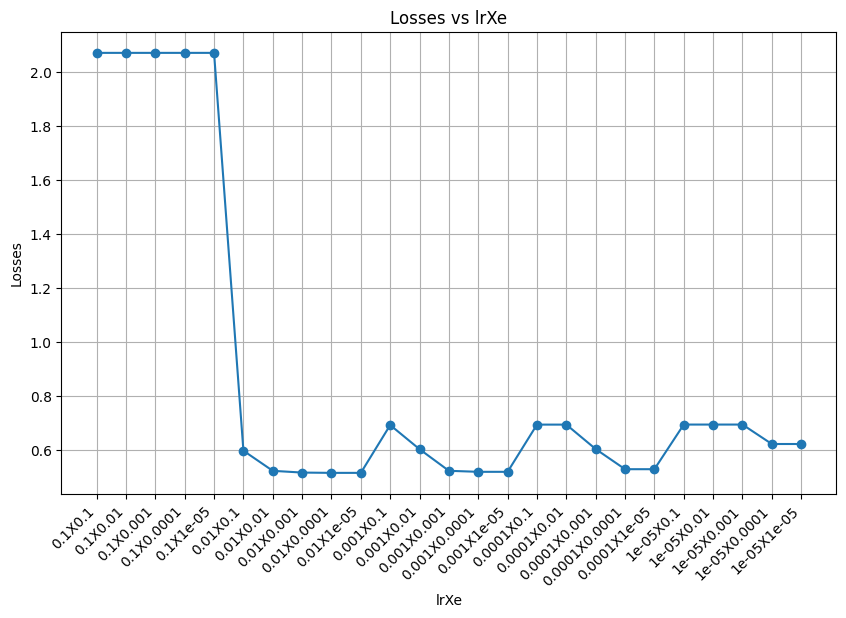

In [47]:
# List of learning rates to try
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
epsilon = [0.1, 0.01, 0.001, 0.0001, 0.00001]
lrXe = []

losses = []

# Iterate through different learning rates and epsilon values
for lr in learning_rates:
    for e in epsilon:
        lrXe.append(str(lr) + "X" + str(e))  # Combine lr and e as a label
        model = LogisticRegression()
        loss = evaluate_learning_rate(model, X_final_train, y_train, learning_rate=lr, e=e)
        losses.append(loss)

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(lrXe, losses, marker='o')  # Plotting lrXe against losses

# Adding title and labels
plt.title('Losses vs lrXe')
plt.xlabel('lrXe')
plt.ylabel('Losses')

# Rotate x labels for better readability
plt.xticks(rotation=45, ha="right")

# Display the plot
plt.grid(True)
plt.show()
